In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline 

Data loading
--

Graphs for individual subjects are adjcacency matrices organized as follows (n_subjects,nrow,ncol) where nrow,ncol are 65 regions. 

Several connectivity measures were calculated : we will use one measure named "tangent" 

In [2]:
allscales = ['scale007','scale036','scale064','scale122','scale444']


In [4]:
curscale = allscales[1]

# Loading data
curfile = "../mpilmbb/fconn_158subjects_%s_regions.npz" % curscale

# Current ATLAS  
roi_maps = '../mpilmbb/basc_2mm_%s.nii.gz' % curscale

X = np.load(curfile)['tangent']
print('X shape (n_subjects,n_regions,n_regions):')
print(X.shape)


X shape (n_subjects,n_regions,n_regions):
(158, 57, 57)


Here is the final list of subject ids. Note that this is the order that is used in the first axis of the X array 

In [5]:
subjfiles = np.load(curfile)['subjectids']

subjids = [cur[60:70] for cur in subjfiles]
print(subjids)

['sub-010044', 'sub-010212', 'sub-010004', 'sub-010046', 'sub-010031', 'sub-010137', 'sub-010228', 'sub-010091', 'sub-010014', 'sub-010054', 'sub-010162', 'sub-010225', 'sub-010205', 'sub-010075', 'sub-010074', 'sub-010127', 'sub-010116', 'sub-010133', 'sub-010171', 'sub-010052', 'sub-010221', 'sub-010002', 'sub-010172', 'sub-010157', 'sub-010122', 'sub-010152', 'sub-010029', 'sub-010060', 'sub-010081', 'sub-010065', 'sub-010099', 'sub-010163', 'sub-010006', 'sub-010027', 'sub-010064', 'sub-010147', 'sub-010033', 'sub-010220', 'sub-010061', 'sub-010103', 'sub-010203', 'sub-010129', 'sub-010130', 'sub-010062', 'sub-010079', 'sub-010128', 'sub-010229', 'sub-010166', 'sub-010035', 'sub-010118', 'sub-010050', 'sub-010096', 'sub-010048', 'sub-010145', 'sub-010071', 'sub-010084', 'sub-010067', 'sub-010226', 'sub-010034', 'sub-010131', 'sub-010090', 'sub-010037', 'sub-010154', 'sub-010098', 'sub-010126', 'sub-010165', 'sub-010136', 'sub-010036', 'sub-010132', 'sub-010117', 'sub-010072', 'sub-

Visualizing the brain parcellation
--
We learnt a brain parcellation using the resting state data from all subjects of the dataset. 

Let's load the file that described the final regions of interest and visualize the 65 regions. 

In [6]:
from nilearn.plotting import plot_prob_atlas,plot_roi
from nilearn.regions import connected_label_regions

labels_maps = connected_label_regions(roi_maps)
plot_roi(labels_maps,cut_coords=8,display_mode='x')

ValueError: File not found: '../mpilmbb/basc_2mm_scale036.nii.gz'

This summarizes all regions over the whole brain. Let's rather plot them one by one.

As this will generate a lot of figures, we create a directory (in the current directory) and directly save the images there.

In [6]:
nrois = np.unique(labels_maps.get_data())[-1]
print("Atlas has %d rois " % nrois)

Atlas has 171 rois 


In [7]:
import os 
from nilearn.image import math_img

if not(os.path.isdir("roi_images_%s" % curscale)):
    os.makedirs("roi_images_%s" % curscale)

from nilearn.image import iter_img
from nilearn.plotting import plot_roi,plot_stat_map


for i in range(1,94):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    
    plot_roi(curimg,title="Region %d" % i)
    plt.savefig("roi_images_basc/roi_%d.png" % i)
    plt.close()

KeyboardInterrupt: 

Let's extract the center of each region, we will need them for further visualization 

In [8]:
from nilearn.plotting import find_xyz_cut_coords


roi_maps_4D = []

for i in range(1,nrois+1):
    curimg = math_img('img == %d' % i ,img=labels_maps)
    roi_maps_4D.append(curimg)
    

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]
coords_connectome = np.stack(coords_connectome)

In [9]:
coords_connectome.shape # Each row is a 3D coordinate of the center of the corresponding region. 

(171, 3)

Now we can visualize connectomes. 

We choose a bunch of them randomly.

Note that the choice of threshold will highly influence visualization.

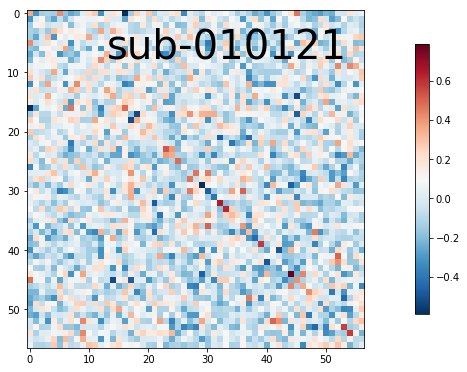

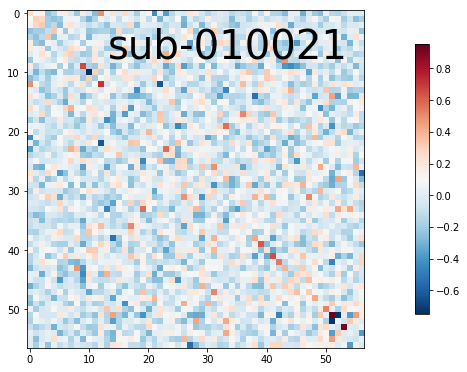

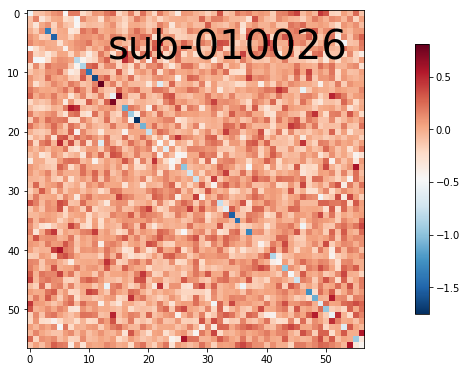

In [8]:
from nilearn.plotting import plot_matrix 

n_subj_to_plot = 3

for i in np.random.choice(len(subjids),n_subj_to_plot):

    plot_matrix(X[i],title='%s' % subjids[i])
    plt.show()

In [7]:
from nilearn.plotting import plot_connectome 

n_subj_to_plot = 3

for i in np.random.choice(len(subjids),n_subj_to_plot):

    curA = k_nearest_neighbor_graph(X[i],2)
    plot_connectome(curA,coords_connectome,edge_threshold='99%',title='%s' % subjids[i])
    plt.show()

NameError: name 'k_nearest_neighbor_graph' is not defined

In [228]:
def k_nearest_neighbor_graph(graph, k):
    ng = np.zeros(graph.shape)
    for i in range(graph.shape[0]):
        a = graph[i, :]
        ind = np.argpartition(a, -(k+1))[-(k+1):]
        for j in range(graph.shape[0]):
            if j in ind and j != i:
                ng[i,j] = graph[i,j]
    for i in range(graph.shape[0]):
        for j in range(graph.shape[0]):
            ng[i,j] = max(ng[i,j], ng[j,i])
    return ng